In [1]:
import requests

import pandas as pd
import numpy as np
# from math import pi, cos,radians, log10, sqrt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord

from astro_calc import ang_distance

from p_grb_assoc import p_ser_grb, sig_est
from fink_request import ft_finder, check_det_hist, explorer_crossmatch

from module_filter import cut_grb_mod

from grb_cat import cat_select
from IPython.display import display, Math

import json

In [2]:
# Load the grb_config file

with open('grb_config.json', 'r') as json_file:
    grb_config = json.load(json_file)
    
cat_file = grb_config['cat_file']
mission_name = grb_config['mission_name']
max_cone_search = grb_config['max_cone_search']
size_time_window = grb_config['size_time_window']
sigma_grb_ass = grb_config['sigma_grb_ass']

# Load the GRB catalog
cat = cat_select(mission_name,cat_file)

#retrieve the catalog informations of the targeted GRB
index_grb = cat.index
i = index_grb[cat.name == grb_config['selected_burst']][0]
grb_name = cat.name[i]
grb_ra = cat.ra[i]
grb_dec = cat.dec[i]
grb_pos = SkyCoord(grb_ra, grb_dec, unit = 'degree', frame='icrs')
grb_pos_err = cat.error_radius[i]# in deg
cone_radius  = min([max_cone_search,1.5*grb_pos_err])*3600
grb_date = cat.trigger_time[i]

# perform a spatial and time crossmatch with the ZTF candidates in Fink
pdf_crossmatch = explorer_crossmatch(grb_ra,grb_dec,cone_radius,grb_date,size_time_window)

# Prepare new columns in the pd data frame
pdf_crossmatch['v:Pser_grb'] = 1.0 # the serendipituous probability of a GRB/ZTF candidate association
pdf_crossmatch['v:grbSigmaAss'] = 0.0 # the confidence level in sigma associated with 1 - pser
pdf_crossmatch['v:ft'] = False # a boolean tag to flag fast evolving transient sources

if len(pdf_crossmatch) > 0:
    k = 0
    # Compute additionnal paramaters (used by the science filters) to be added in the alert pd frame
    # Here it is slow because of the while loop..... Should change from a future Fink update release
    while k<len(pdf_crossmatch):
        if check_det_hist(pdf_crossmatch['i:objectId'].values[k],grb_date):
            delay =  Time(pdf_crossmatch['v:lastdate'].values[k])-Time(grb_date)
            sep = ang_distance([grb_ra,grb_dec],
                               [pdf_crossmatch['i:ra'].values[k],
                                pdf_crossmatch['i:dec'].values[k]])
            # if a positive match, compute the probability of association by chance knowing the GRB error box
            # and the delay between the ZTF candidate and the GRB trigger time
            p_grb = p_ser_grb(grb_pos_err,delay.value/365.25,250)
            pdf_crossmatch['v:Pser_grb'].values[k] = p_grb[0]
            sigma_ass = sig_est(1-p_grb[0])
            pdf_crossmatch['v:grbSigmaAss'].values[k] = sigma_ass[0]
        k = k+1
    
    print(grb_name+" position is: RA = "+str(grb_ra)+" dec = "+str(grb_dec)+\
              " error radius = "+str(cone_radius/3600)+" degrees")
    print(grb_name+" has a positive (time and space) match with "+str(len(pdf_crossmatch))+\
          " ZTF candidates before applying the science cuts")
    print("\r\n")
    
    # Apply the science filter cuts 
    pdf_sel = cut_grb_mod(pdf_crossmatch,grb_config)
    
    if len(pdf_sel) > 0:
        print("There is at least one ZTF candidate with a credible association with the "+\
             "Fermi "+grb_name)
        print("List of identified ZTF transient candidates:")
        print(pdf_sel['i:objectId'])
        
        # Make deeper searches to tag fast evolving transients
        pdf_ft = ft_finder(pdf_sel,grb_date)
        # print messages when fast evolving transients are found
        if len(pdf_ft)>0:
            print("There are "+str(len(pdf_ft))+" fast transient sources"+\
                  "with a positive crossmatch with the Fermi "+grb_name)
            print("List of identified fast transient sources:\r\n")
            k = 0
            while k<len(pdf_ft['i:objectId']):
                delay =  Time(pdf_ft['v:lastdate'].values[k])-Time(grb_date)
                sep = ang_distance([grb_ra,grb_dec],
                               [pdf_ft['i:ra'].values[k],
                                pdf_ft['i:dec'].values[k]])
                print(pdf_ft['i:objectId'].values[k]+" is located "+\
                      str("{:.2f}".format(sep.degree))+" degrees away from "+grb_name+\
                      " and detected "+str("{:.4f}".format(delay.value*24))+\
                      " hours post GRB trigger time.\nThe association significance is "+\
                      str("{:.4f}".format(pdf_ft['v:grbSigmaAss'].values[k]))+" sigma")
                k = k+1
    else:
        print("Their is no credible association between "+grb_name+" and the "+\
              "ZTF candidates after applying the science cuts")
        
        print("Ongoing search for a fast transient association under the "+\
              str(sigma_grb_ass)+" sigma C.L. threshold....\r\n")
        
        # Look at the possible fast transients that have a positive crossmatch
        pdf_ft = ft_finder(pdf_crossmatch,grb_date)
        if len(pdf_ft)>0:
            print("There are "+str(len(pdf_ft))+" fast transient source(s) with a positive "+\
                  "crossmatch with the Fermi "+grb_name)
            print("List of identified fast transient sources:\r\n")
            print(pdf_ft['i:objectId'])
        else:
            print("No fast transient identified in the ZTF candidate list with a positive match\r\n")

else:
    print(grb_name+" position is: RA = "+str(grb_ra)+" dec = "+str(grb_dec)+\
              " error radius = "+str(cone_radius/3600)+" degrees")
    print(grb_name+" has NO match with any ZTF candidates within "+str(size_time_window)+\
          " days post trigger time")
    print("\r\n")

GRB210204270 position is: RA = 116.12 dec = 12.7 error radius = 1.98 degrees
GRB210204270 has a positive (time and space) match with 89 ZTF candidates before applying the science cuts


Their is no credible association between GRB210204270 and the ZTF candidates after applying the science cuts
Ongoing search for a fast transient association under the 5 sigma C.L. threshold....

There are 1 fast transient source(s) with a positive crossmatch with the Fermi GRB210204270
List of identified fast transient sources:

54    ZTF21aagwbjr
Name: i:objectId, dtype: object


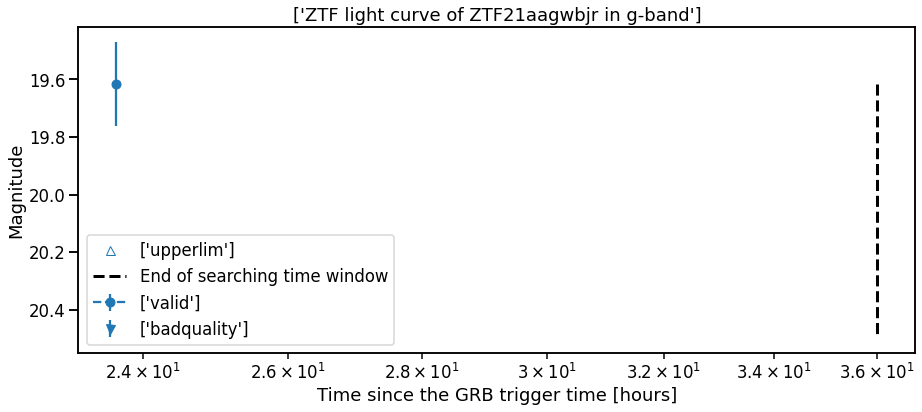

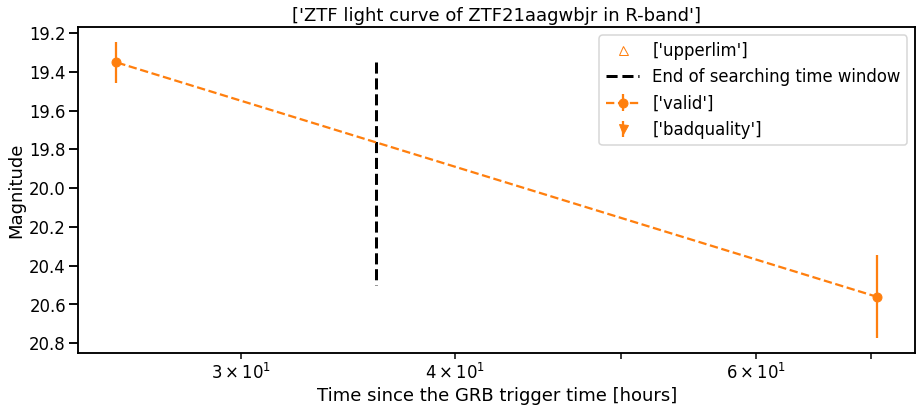

In [3]:
# Plot the light curves of the fast rising/fading transients
colordic = {1: 'C0', 2: 'C1'}
filter_label = {1: 'g', 2: 'R'}
k = 0

if len(pdf_sel) == 0 and len(pdf_ft) > 0:
    pdf_plot = pdf_ft
elif len(pdf_sel) > 0 and len(pdf_ft) > 0:
    pdf_plot = pdf_ft
elif len(pdf_sel) > 0 and len(pdf_ft) == 0:
    pdf_plot = pdf_sel
elif len(pdf_sel) == 0 and len(pdf_ft) == 0:
    pdf_plot = []
    
for objects in pdf_plot.loc[pdf_plot['v:ft'] == True,'i:objectId']:

    # get data for the candidate
    r = requests.post(
      'https://fink-portal.org/api/v1/objects',
      json={
        'objectId': objects,
        'output-format': 'json',
        'withupperlim': 'True'
      }
    )
    

    # Format output in a DataFrame
    pdf_cand = pd.read_json(r.content)
    
    # filter out the data point before the GRB  trigger time
    mask_grbtime = pdf_cand['i:jd']>grb_date.jd
    
    # setup the time unit for the light curve
    unit_time_factor = 24 # here in hour (86400 in sec, 1440 in min, 24 in hour)
    for filt in np.unique(pdf_cand['i:fid']):
        fig = plt.figure(figsize=(15, 6))
        maskFilt = pdf_cand['i:fid'] == filt
        if filt == '1':
            pdf_cand_gband = pdf_cand[maskFilt]
        elif filt == '2':
            pdf_cand_Rband = pdf_cand[maskFilt]
    #     print(pdf_cand)
        # The column `d:tag` is used to check data type
        maskValid = pdf_cand['d:tag'] == 'valid'
        plt.errorbar(
            pdf_cand[maskValid & maskFilt & mask_grbtime]['i:jd'].\
            apply(lambda x: (x - grb_date.jd)*unit_time_factor),
            pdf_cand[maskValid & maskFilt & mask_grbtime]['i:magpsf'],
            pdf_cand[maskValid & maskFilt & mask_grbtime]['i:sigmapsf'],
            ls = '--', marker='o', color=colordic[filt], label=['valid']
        )

        maskUpper = pdf_cand['d:tag'] == 'upperlim'
        plt.plot(
            pdf_cand[maskUpper & maskFilt & mask_grbtime]['i:jd'].\
            apply(lambda x: (x - grb_date.jd)*unit_time_factor),
            pdf_cand[maskUpper & maskFilt & mask_grbtime]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none', label=['upperlim']
        )

        maskBadquality = pdf_cand['d:tag'] == 'badquality'
        plt.errorbar(
            pdf_cand[maskBadquality & maskFilt & mask_grbtime]['i:jd'].\
            apply(lambda x: (x - grb_date.jd)*unit_time_factor),
            pdf_cand[maskBadquality & maskFilt & mask_grbtime]['i:magpsf'],
            pdf_cand[maskBadquality & maskFilt & mask_grbtime]['i:sigmapsf'],
            ls='', marker='v', color=colordic[filt], label=['badquality']
        )
        if pdf_cand[maskValid & maskFilt]['i:magpsf'].size > 0:
#             plt.plot([0,0],
#                      [min(pdf_cand[maskValid & maskFilt & mask_grbtime]['i:magpsf']),20.5],
#                      ls='--',lw=3,c='red',label='GRB trigger time')
            plt.plot([size_time_window*unit_time_factor,size_time_window*unit_time_factor],
                     [min(pdf_cand[maskValid & maskFilt & mask_grbtime]['i:magpsf']),20.5],
                     ls='--',lw=3,c='black',label='End of searching time window')

        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Time since the GRB trigger time [hours]')
        plt.ylabel('Magnitude')
        plt.title('ZTF light curve of '+np.unique(pdf_cand['i:objectId'].values)+" in "+\
                  filter_label[filt]+"-band")
        plt.legend(loc='best')
        plt.show()